In [1]:
# expand cells to the 95% of the display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

# Tutorial: Automatic rule-based modeling of the *Escherichia coli* lactose metabolism, including protein-protein interactions and regulation of gene expression employing *Atlas*

Authors: Rodrigo Santibáñez[1,2], Daniel Garrido[2], and Alberto Martín[1]

Date: August 2020

Affiliations:
1. Centro de Genómica y Bioinformática, Facultad de Ciencias, Universidad Mayor, Santiago, 8580745, Chile.
2. Department of Chemical and Bioprocess Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Santiago, 7820436, Chile

Notes: This tutorial was created for the manuscript "*Atlas*: Automatic modeling of regulation of bacterial gene expression and metabolism using rule-based languages", first submitted for peer-review to Bioinformatics on May, 2020.

## Prerequisites

0. The tutorial was prepared and executed on Ubuntu 20.04, PathwayTools version 24, and docker engine version 19.03.8.<br/><br/>

1. PathwayTools must be installed and running to obtain data from the EcoCyc database. Please, run ```pathway-tools -lisp -python-local-only``` before to obtain any data.<br/>
   (Optional) The PathwayTools software could be executed in the background, with help of ```nohup pathway-tools -lisp -python-local-only > /dev/null 2> /dev/null &```.<br/>
   Please follow instructions at http://pathwaytools.org/ to obtain a licensed copy of the software from https://biocyc.org/download-bundle.shtml. However, data could be manually formatted using a text-based editor or a spreadsheet software.
   
   Note: If you ran into the ```pathway-tools/aic-export/pathway-tools/ptools/22.5/exe/aclssl.so: undefined symbol: CRYPTO_set_locking_callback``` error, please follow instructions here: https://github.com/glucksfall/atlas/tree/master/PTools. Instructions will guide you to install a docker image that is able to run pathway tools, but does not include it, so you still need to obtain the software with a valid license.<br/><br/>
   
2. (Highly recommended) Install Docker. Please follow instructions for a supported Operating System https://docs.docker.com/engine/install/:<br/>
   On Ubuntu, install it with ```apt-get install docker.io```.<br/>
   On Win10, install Docker Desktop with WSL2 support https://docs.docker.com/docker-for-windows/wsl/.<br/>
   On MacOS, install Docker Desktop https://docs.docker.com/docker-for-mac/install/.<br/><br/>
   The Docker ```networkbiolab/pleiades```installs the python packages, the jupyter server, and the stochastic simulators.<br/><br/>

3. (Recommended) Jupyter notebook. We recommend the use of Anaconda3 https://www.anaconda.com/products/individual because of the easier installation of the stochastic simulators from https://anaconda.org/alubbock.<br/><br/>

4. (Optional) A stochastic simulator, supported by the pySB python package ([BNG2](https://github.com/RuleWorld/bionetgen), [NFsim](https://github.com/ruleworld/nfsim/tree/9178d44455f6e27a81f398074eeaafb2a1a4b4bd), [KaSim](https://github.com/Kappa-Dev/KappaTools) or [Stochkit](https://github.com/StochSS/StochKit)). pySB requires BNG2 to simulate models with NFsim.<br/><br/>

5. (Optional) Cytoscape to visualize metabolic networks and others.

## Preamble: load *Atlas*

In [2]:
# testing source code
import sys
sys.path.append("../..") # If installed from GitHub and this notebooks is executed from the example/subfolder directory.

import atlas_rbm.atlas as atlas
import atlas_rbm.utils as utils
import atlas_rbm.export as export
import atlas_rbm.simulation as simulation

## Modeling protein-protein interactions

Once we curated the metabolic network, we modeled next the protein-protein interaction network which connects gene expression to the metabolism for reactions performed by protein complexes. We employed the collapsed hyper-network representation (brackets denotes a complex of agents) to describe the protein-protein interactions from literature or assumptions and automated the modeling of assembly processes. For instance, the assembly process for the $\beta$-galactosidase tetramer comes from dimers and we supposed of the existence of a galactoside O-acetyltransferase dimer as pre-complex prior to the trimer:

In [3]:
atlas.read_network('input_networks/network-lac-ProtProt.tsv')

,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,lacZ,lacZ,1.0,0.0,cytosol
1,"[lacZ,lacZ]","[lacZ,lacZ]",1.0,0.0,cytosol
2,lacA,lacA,1.0,0.0,cytosol
3,lacA,"[lacA,lacA]",1.0,0.0,cytosol
4,lacI,lacI,1.0,0.0,cytosol


In [4]:
%time model1 = atlas.construct_model_from_interaction_network('input_networks/network-lac-ProtProt.tsv')
model1

CPU times: user 342 ms, sys: 20.2 ms, total: 362 ms
Wall time: 360 ms


<Model 'atlas_rbm.construct_model_from_interaction_network' (monomers: 1, rules: 5, parameters: 18, expressions: 0, compartments: 0) at 0x7fd4d3863d90>

To complement the model of protein-protein interaction to a model of metabolism, we must match the description of agents. In this case, and on contrast to the `tutorial - 1A - lactose degradation.ipynb`, reactions are performed by enzymes with the same name as the proteins:

In [5]:
utils.read_network('input_networks/network-lac-metabolism-complex.tsv') # for simplicity of the output

,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,spontaneous,cytosol,LACTOSE-MUTAROTATION,alpha-lactose,beta-lactose,1,1
1,spontaneous,cytosol,GALACTOSE-MUTAROTATION,alpha-GALACTOSE,beta-GALACTOSE,1,1
2,spontaneous,cytosol,GLUCOSE-MUTAROTATION,alpha-glucose,beta-glucose,1,1
3,lacY,inner membrane,TRANS-RXN-24,"PER-PROTON,PER-alpha-lactose","PROTON,alpha-lactose",1,0
4,lacY,inner membrane,TRANS-RXN-24-beta,"PER-PROTON,PER-beta-lactose","PROTON,beta-lactose",1,0
5,lacY,inner membrane,TRANS-RXN-94,"PER-PROTON,PER-MELIBIOSE","PROTON,MELIBIOSE",1,0
6,lacY,inner membrane,RXN0-7215,"PER-PROTON,PER-CPD-3561","PROTON,CPD-3561",1,0
7,lacY,inner membrane,RXN0-7217,"PER-PROTON,PER-CPD-3785","PROTON,CPD-3785",1,0
8,lacY,inner membrane,RXN-17755,"PER-PROTON,PER-CPD-3801","PROTON,CPD-3801",1,0
9,"[lacZ,lacZ,lacZ,lacZ]","[cytosol,cytosol,cytosol,cytosol]",BETAGALACTOSID-RXN,"beta-lactose,WATER","beta-GALACTOSE,beta-glucose",1,0


In [6]:
%time model2 = atlas.construct_model_from_metabolic_network('input_networks/network-lac-metabolism-complex.tsv', verbose = False) # read a file to build a model
model2

CPU times: user 691 ms, sys: 12.3 ms, total: 703 ms
Wall time: 702 ms


<Model 'atlas_rbm.construct_model_from_metabolic_network' (monomers: 2, rules: 18, parameters: 61, expressions: 0, compartments: 0) at 0x7fd4d376a4c0>

We created a second model, and next, we need to combine both models into one:

In [7]:
%time combined = atlas.combine_models([model1, model2])
combined

CPU times: user 858 ms, sys: 3.71 ms, total: 861 ms
Wall time: 857 ms


<Model 'atlas_rbm.atlas' (monomers: 2, rules: 23, parameters: 75, expressions: 0, compartments: 0) at 0x7fd4d376a7c0>

Please note the number of rules of the `combined` model in comparison with `model1` (protein-protein interactions) and `model2` (metabolism). Next, we continue similarly as before, setting the initial condition, performing simulations, and plotting the results:

In [8]:
# initial condition
# for metabolites (set again doesn't hurt)
simulation.set_initial.met(combined, 'beta_lactose', 'per', 100)
simulation.set_initial.met(combined, 'PROTON', 'per', 100) # required for lactose transport
simulation.set_initial.met(combined, 'WATER', 'cyt', 100) # required for lactose hydrolysis

# for proteins
simulation.set_initial.prot(combined, 'lacY', 'imem', 1)
simulation.set_initial.prot(combined, 'lacZ', 'cyt', 4)
simulation.set_initial.prot(combined, 'lacA', 'cyt', 3)

# and for complexes. We set to zero to simulate complex assembly as a requisite for metabolic activity
simulation.set_initial.cplx(combined, 'lacAx3', 'cyt', 0) # the codename for complexes is the monomer names times the stoichiometry
simulation.set_initial.cplx(combined, 'lacZx4', 'cyt', 0)

# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'

%time data1 = simulation.scipy(combined, start = 0, finish = 10, points = 500)
%time data2 = simulation.bngSSA(combined, start = 0, finish = 10, points = 500, n_runs = 100, path = bng)

Initial t0_met_beta_lactose not found. Creating Initial t0_met_beta_lactose...
Initial t0_met_PROTON not found. Creating Initial t0_met_PROTON...
Initial t0_prot_lacY not found. Creating Initial t0_prot_lacY...
CPU times: user 4.01 s, sys: 818 ms, total: 4.83 s
Wall time: 4.72 s
CPU times: user 6.01 s, sys: 244 ms, total: 6.25 s
Wall time: 12 s


In [9]:
import seaborn
import matplotlib.pyplot as plt

for key in [
#     'figure.titlesize',
    'font.size',
#     'legend.fontsize',
#     'legend.title_fontsize',
    'font.size', 
#     'xtick.labelsize',
    'xtick.major.size',
    'xtick.minor.size',
#     'ytick.labelsize',
    'ytick.major.size',
    'ytick.minor.size']:
    plt.rcParams[key] = plt.rcParams[key] * 1.1

palette = seaborn.color_palette('colorblind')

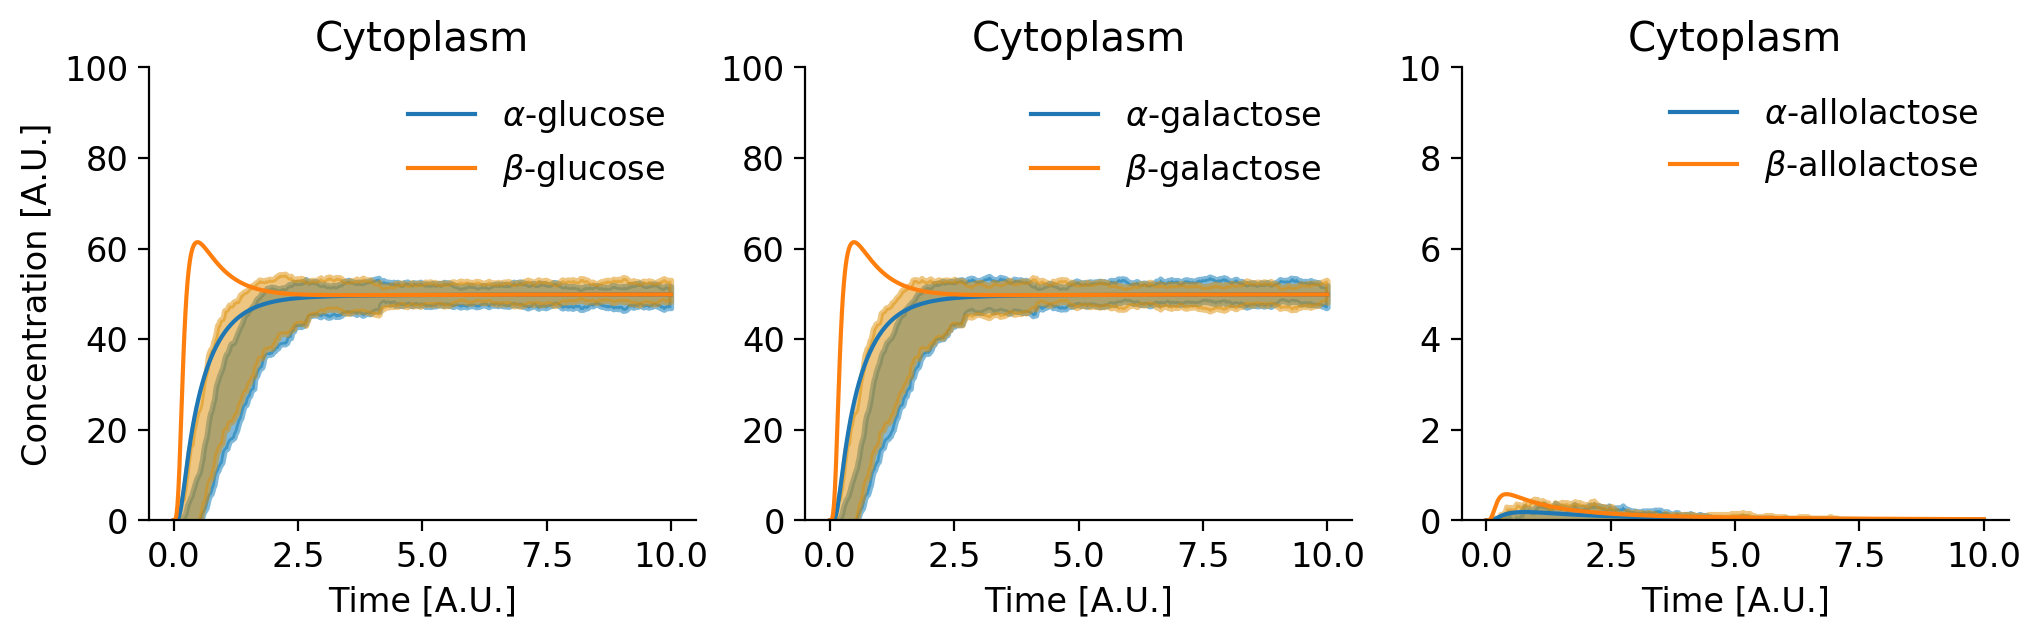

In [10]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 3, figsize = (4*3, 3*1), dpi = 200)

# first plot, lactose concentration
simulation.plot.metabolite(data1, 'alpha-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\alpha$-glucose'})
simulation.plot.metabolite(data1, 'beta-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\beta$-glucose'})

simulation.plot.metabolite(
    data2, 'alpha-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# second plot, galactose concentration
simulation.plot.metabolite(data1, 'alpha-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\alpha$-galactose'})
simulation.plot.metabolite(data1, 'beta-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\beta$-galactose'})

simulation.plot.metabolite(
    data2, 'alpha-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# third plot, allolactose concentration
simulation.plot.metabolite(data1, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\alpha$-allolactose'})
simulation.plot.metabolite(data1, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\beta$-allolactose'})

simulation.plot.metabolite(
    data2, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 100, bottom = 0)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Cytoplasm')
ax[1].set_ylim(top = 100, bottom = 0)

ax[2].set_xlabel('Time [A.U.]')
ax[2].set_title('Cytoplasm')
ax[2].set_ylim(top = 10, bottom = 0)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)
ax[2].legend(frameon = False)

seaborn.despine()
plt.show()

Additionally, we must took into consideration the reaction stoichiometry for each enzymatic complex. In this curation step, we identified if reactions could happen independently of complex assembly (i.e., monomers are catalytically active) or if the protein complex is necessary for the catalytic activity *in vivo* (i.e., monomers are inactive).

## Correcting rules: $\beta$-galactosidase and galactoside O-acetyltransferase activity per monomer, not per complex.

For the $\beta$-galactosidase complex, each subunit is catalytically active only when the tetramer is assembled. Similarly, the galactoside O-acetyltransferase active sites act independently of each other and since they are formed with residues from two adjacent monomers the trimer was assumed as the only active catalytic form.

We could explore rules by their indexes, and leverage the rule-based language to model the desired behavior. For the case of monomers with catalytic activity **after** the assembly of the complex, we must redefine the metabolic network modifying the enzyme necessary for the reaction:

`prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=None)` to `prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY)`.

**Note**: The keywork `ANY` means the site is linked to any *agent* without the necessity of its explicit definition.

In [11]:
%time model2 = atlas.construct_model_from_metabolic_network('input_networks/network-lac-metabolism-complex.tsv', verbose = False) # read a file to build a model
model2.rules[9]

CPU times: user 768 ms, sys: 4.2 ms, total: 772 ms
Wall time: 770 ms


Rule('BETAGALACTOSID_RXN', prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=None) + met(name='beta_lactose', loc='cyt', dna=None, met=None, prot=None, rna=None) + met(name='WATER', loc='cyt', dna=None, met=None, prot=None, rna=None) | prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=None) + met(name='beta_GALACTOSE', loc='cyt', dna=None, met=None, prot=None, rna=None) + met(name='beta_glucose', loc='cyt', dna=None, met=None, p

In [12]:
new_rule = "Rule('BETAGALACTOSID_RXN', \
            prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY) + \
            met(name='beta_lactose', loc='cyt', prot=None) + \
            met(name='WATER', loc='cyt', prot=None) | \
            prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY) + \
            met(name='beta_GALACTOSE', loc='cyt', prot=None) + \
            met(name='beta_glucose', loc='cyt', prot=None), \
            fwd_BETAGALACTOSID_RXN, rvs_BETAGALACTOSID_RXN)"
            
model2 = atlas.replace_rule(model2, 'BETAGALACTOSID_RXN', new_rule)

In [13]:
combined.rules[-1] # the new rule appears at the end of the "rules" list

Rule('TRANS_RXN_94', prot(dna=None, dw=None, loc='imem', met=None, name='lacY', prot=None, rna=None, up=None) + met(name='PROTON', loc='per', dna=None, met=None, prot=None, rna=None) + met(name='MELIBIOSE', loc='per', dna=None, met=None, prot=None, rna=None) | prot(dna=None, dw=None, loc='imem', met=None, name='lacY', prot=None, rna=None, up=None) + met(name='PROTON', loc='cyt', dna=None, met=None, prot=None, rna=None) + met(name='MELIBIOSE', loc='cyt', dna=None, met=None, prot=None, rna=None), fwd_TRANS_RXN_94, rvs_TRANS_RXN_94)

Because modifying one rule at the time could be tedious, we could speed up the process if the same modification could be applied to multiple rules:

In [14]:
model2 = atlas.modify_rules(
    model2, 
    oldString = "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=None)",
    
    newString = "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY)",
    names = [
        'BETAGALACTOSID_RXN',
        'BETAGALACTOSID_RXN_alpha', 
        'RXN0_5363', 
        'RXN0_5363_beta', 
        'ALLOLACTOSE_DEG_alpha', 
        'ALLOLACTOSE_DEG_beta', 
        'RXN_17726', 
        'RXN0_7219'])

In [15]:
model2 = atlas.modify_rules(
    model2, 
    oldString = "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % " \
                "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % " \
                "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=None)",
    
    newString = "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY)",
    names = ['GALACTOACETYLTRAN_RXN_galactose'])

The `modify_rules()` and `replace_rule()` functions remove the old rules and add the rule. Therefor, the new rules appears at the end of the `model.rules` object:

In [16]:
model2.rules[-1]

Rule('GALACTOACETYLTRAN_RXN_galactose', prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=ANY, dw=ANY) + met(name='beta_GALACTOSE', loc='cyt', dna=None, met=None, prot=None, rna=None) + met(name='ACETYL_COA', loc='cyt', dna=None, met=None, prot=None, rna=None) | prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=ANY, dw=ANY) + met(name='_6_Acetyl_beta_D_Galactose', loc='cyt', dna=None, met=None, prot=None, rna=None) + met(name='CO_A', loc='cyt', dna=None, met=None, prot=None, rna=None), fwd_GALACTOACETYLTRAN_RXN_galactose, rvs_GALACTOACETYLTRAN_RXN_galactose)

However, the modifications are only the first part. If we consider that both `up` and `dw` sites are now defined to match an *agent* linked to two others at both *sides*, we must correct the protein-protein interactions:

In [17]:
%time model1 = atlas.construct_model_from_interaction_network('input_networks/network-lac-ProtProt.tsv')
model1.rules[-1]

CPU times: user 192 ms, sys: 385 µs, total: 192 ms
Wall time: 190 ms


Rule('PhysicalInteractionRule_5', prot(name='lacI', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None) + prot(name='lacI', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None) | prot(name='lacI', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='lacI', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=None), fwd_PhysicalInteractionRule_5, rvs_PhysicalInteractionRule_5)

In [18]:
new_rule = "Rule('PhysicalInteractionRule_2', "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=2) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=None) + "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=None) | "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=4, dw=1) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=4), "\
            "fwd_PhysicalInteractionRule_2, rvs_PhysicalInteractionRule_2)"

model1 = atlas.replace_rule(model1, 'PhysicalInteractionRule_2', new_rule)

In [19]:
new_rule = "Rule('PhysicalInteractionRule_4', "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None) + "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=None) | "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=1) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3), "\
            "fwd_PhysicalInteractionRule_4, rvs_PhysicalInteractionRule_4)"

model1 = atlas.replace_rule(model1, 'PhysicalInteractionRule_4', new_rule)

In [20]:
%time combined = atlas.combine_models([model1, model2])
combined

CPU times: user 863 ms, sys: 7.95 ms, total: 870 ms
Wall time: 869 ms


<Model 'atlas_rbm.atlas' (monomers: 2, rules: 23, parameters: 75, expressions: 0, compartments: 0) at 0x7fd4d010a310>

In [21]:
# initial condition
# for metabolites (set again doesn't hurt)
simulation.set_initial.met(combined, 'beta_lactose', 'per', 100)
simulation.set_initial.met(combined, 'PROTON', 'per', 100) # required for lactose transport
simulation.set_initial.met(combined, 'WATER', 'cyt', 100) # required for lactose hydrolysis

# for proteins
simulation.set_initial.prot(combined, 'lacY', 'imem', 1)
simulation.set_initial.prot(combined, 'lacZ', 'cyt', 4)
simulation.set_initial.prot(combined, 'lacA', 'cyt', 3)

# and for complexes. We set to zero to simulate complex assembly as a requisite for metabolic activity
simulation.set_initial.cplx(combined, 'lacAx3', 'cyt', 0) # the codename for complexes is the monomer names times the stoichiometry
simulation.set_initial.cplx(combined, 'lacZx4', 'cyt', 0)

# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'

%time data1 = simulation.scipy(combined, start = 0, finish = 10, points = 500)
%time data2 = simulation.kasim(combined, start = 0, finish = 10, points = 500, n_runs = 100, path = kasim)

Initial t0_met_beta_lactose not found. Creating Initial t0_met_beta_lactose...
Initial t0_met_PROTON not found. Creating Initial t0_met_PROTON...
Initial t0_prot_lacY not found. Creating Initial t0_prot_lacY...
CPU times: user 3.39 s, sys: 728 ms, total: 4.11 s
Wall time: 3.62 s
CPU times: user 4.2 s, sys: 844 ms, total: 5.05 s
Wall time: 12.1 s


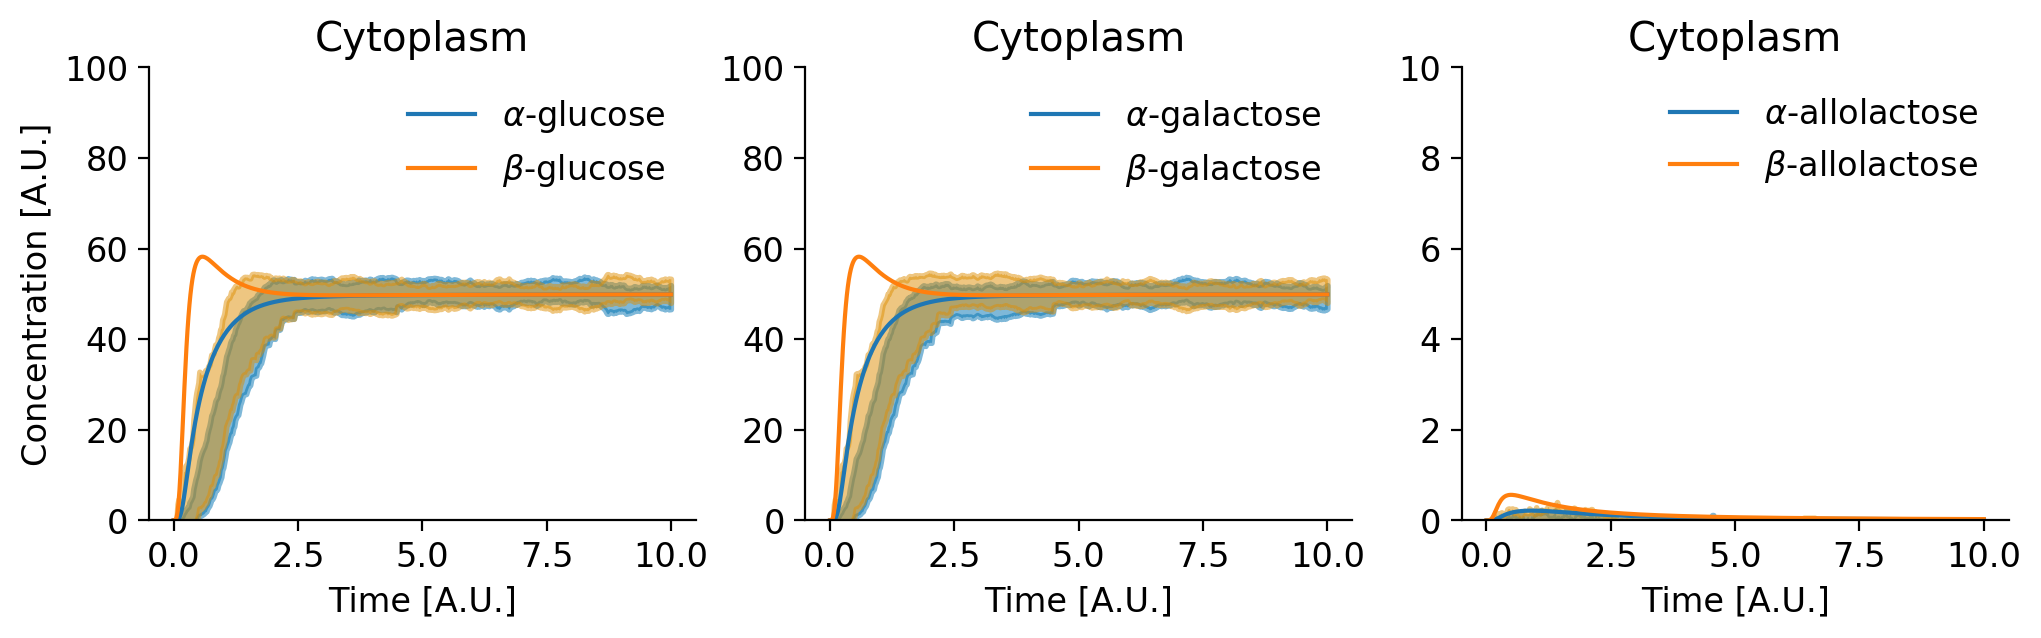

In [22]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 3, figsize = (4*3, 3*1), dpi = 200)

# first plot, lactose concentration
simulation.plot.metabolite(data1, 'alpha-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\alpha$-glucose'})
simulation.plot.metabolite(data1, 'beta-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\beta$-glucose'})

simulation.plot.metabolite(
    data2, 'alpha-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# second plot, galactose concentration
simulation.plot.metabolite(data1, 'alpha-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\alpha$-galactose'})
simulation.plot.metabolite(data1, 'beta-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\beta$-galactose'})

simulation.plot.metabolite(
    data2, 'alpha-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# third plot, allolactose concentration
simulation.plot.metabolite(data1, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\alpha$-allolactose'})
simulation.plot.metabolite(data1, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\beta$-allolactose'})

simulation.plot.metabolite(
    data2, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 100, bottom = 0)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Cytoplasm')
ax[1].set_ylim(top = 100, bottom = 0)

ax[2].set_xlabel('Time [A.U.]')
ax[2].set_title('Cytoplasm')
ax[2].set_ylim(top = 10, bottom = 0)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)
ax[2].legend(frameon = False)

seaborn.despine()
plt.savefig('figure_1B.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1B.png', format = 'png', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1B.jpg', format = 'jpg', bbox_inches = 'tight', dpi = 300)

plt.show()

The deterministic and stochastic simulations disagree at the beginning of the dynamics, although they reached a similar steady-state. As the stochastic simulation requires the assembly of enzyme complexes before performing any metabolic reaction, they show a lag-phase in contrast to the deterministic simulation.

Please, continue the tutorial opening the `tutorial - 1C - lactose degradation.ipynb` notebook where we will show how to model transcription, translation, control of gene expression, and merge it with the interaction and the metabolic models.